## References

Resamplings
- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
- https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

## Initialization

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

## Load Dataset

In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

## Data Preparation

In [3]:
# since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
# RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015, 3, 17)
df_transactions['recent'] = campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent'] = df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


### Create CLV variables

In [4]:
# create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg(
    {
        'recent': lambda x: x.min(),                     # Recency
        'customer_id': lambda x: len(x),                 # Frequency
        'tran_amount': lambda x: x.sum(),                # Monetary Value
        'trans_date': lambda x: (x.max() - x.min()).days # AOU
    }
)

df_clv.rename(
    columns={
        'recent': 'recency',
        'customer_id': 'frequency',
        'tran_amount': 'monetary_value',
        'trans_date': 'AOU'
    },
    inplace=True
)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']
df_clv = df_clv.join(
    df_transactions.groupby('customer_id').agg(
        ticket_size_std=('tran_amount', 'std'),
        ticket_size_med=('tran_amount', 'median'),
        ticket_size_min=('tran_amount', 'min'),
        ticket_size_max=('tran_amount', 'max'),
    )
)

df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,ticket_size_std,ticket_size_med,ticket_size_min,ticket_size_max
0,CS1112,62.0,15,1012,1309,67.466667,19.766012,63.0,36,105
1,CS1113,36.0,20,1490,1354,74.500000,21.254102,79.5,36,98
2,CS1114,33.0,19,1432,1309,75.368421,21.341692,79.0,37,105
3,CS1115,12.0,22,1659,1303,75.409091,18.151896,72.5,41,104
4,CS1116,204.0,13,857,1155,65.923077,22.940000,60.0,40,105


### Calculating response rate

In [5]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


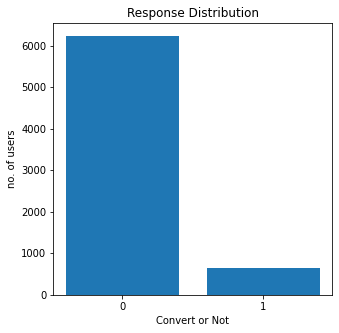

In [6]:
plt.figure(figsize=(5, 5))
x = range(2)
plt.bar(x, response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [7]:
# merging two data sets - CLV

df_modeling_clv = pd.merge(df_response, df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size,ticket_size_std,ticket_size_med,ticket_size_min,ticket_size_max
0,CS1112,0,62.0,15,1012,1309,67.466667,19.766012,63.0,36,105
1,CS1113,0,36.0,20,1490,1354,74.500000,21.254102,79.5,36,98
2,CS1114,1,33.0,19,1432,1309,75.368421,21.341692,79.0,37,105
3,CS1115,1,12.0,22,1659,1303,75.409091,18.151896,72.5,41,104
4,CS1116,1,204.0,13,857,1155,65.923077,22.940000,60.0,40,105


## Creating train and test dataset

In [8]:
# spliting dataframe into X and y

X_clv = df_modeling_clv.drop(columns=['response', 'customer_id'])
y_clv = df_modeling_clv['response']

## Variables

### Matrix

In [9]:
matrix_columns = ['model', 'resampler', 'train-mean', 'train-min', 'train-max', 'test-mean', 'test-min', 'test-max']

### Cross Validations

In [10]:
cv = StratifiedKFold(n_splits=5)

### Resampling Function

In [11]:
random_state = None
undersampler = RandomUnderSampler(random_state=random_state)
oversampler = RandomOverSampler(random_state=random_state)
smote = SMOTE(random_state=random_state)
smote_tomek = SMOTETomek(random_state=random_state)

resamplers = [
    ('n/a', None),
    ('undersampler', undersampler),
    ('oversampler', oversampler),
    ('smote', smote),
    ('smote-tomek', smote_tomek)
]

def get_resampling_data(x, y, resampler):
    if resampler:
        return resampler.fit_resample(x, y)
    return x, y

## Logistic Regression

In [12]:
def logistic_regression_cross_validation_score(resampler):
    train_scores = []
    test_scores = []

    for train_index, test_index in cv.split(X_clv, y_clv):
        # Fold data
        X_train_fold, y_train_fold = X_clv.iloc[train_index], y_clv.iloc[train_index]
        X_test_fold, y_test_fold = X_clv.iloc[test_index], y_clv.iloc[test_index]

        # Resampling data
        X_train_resample, y_train_resample = get_resampling_data(X_train_fold, y_train_fold, resampler)

        # Fit with resample data
        model = LogisticRegression(solver='liblinear', class_weight='balanced')
        model.fit(X_train_resample, y_train_resample)

        # Get AUC score
        train_scores += [roc_auc_score(y_train_resample, model.decision_function(X_train_resample))]
        test_scores += [roc_auc_score(y_test_fold, model.decision_function(X_test_fold))]

    return train_scores, test_scores

In [13]:
logistic_results = []
for resampler_name, resampler in resamplers:
    train_scores, test_scores = logistic_regression_cross_validation_score(resampler)
    logistic_results += [(
        "logistic", 
        resampler_name, 
        np.mean(train_scores), np.min(train_scores), np.max(train_scores), 
        np.mean(test_scores), np.min(test_scores), np.max(test_scores)
    )]
logistic_results = pd.DataFrame(logistic_results, columns=matrix_columns)
logistic_results

,model,resampler,train-mean,train-min,train-max,test-mean,test-min,test-max
0,logistic,n/a,0.729881,0.702982,0.750309,0.734630,0.637293,0.897677
1,logistic,undersampler,0.732716,0.706441,0.755415,0.729527,0.634330,0.887469
2,logistic,oversampler,0.730112,0.701658,0.750258,0.727977,0.631895,0.877567
3,logistic,smote,0.746499,0.729031,0.757130,0.695957,0.635696,0.783240
4,logistic,smote-tomek,0.749581,0.713968,0.769619,0.700381,0.634323,0.797576


## XGBoost

In [14]:
def xgboost_cross_validation_score(resampler):
    train_scores = []
    test_scores = []

    for train_index, test_index in cv.split(X_clv, y_clv):
        # Fold data
        X_train_fold, y_train_fold = X_clv.iloc[train_index], y_clv.iloc[train_index]
        X_test_fold, y_test_fold = X_clv.iloc[test_index], y_clv.iloc[test_index]

        # Resampling data
        X_train_resample, y_train_resample = get_resampling_data(X_train_fold, y_train_fold, resampler)

        # Fit with resample data
        model = xgb_model = xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric="auc",
            base_score=0.5,
            learning_rate=0.01,
            n_estimators=5000,
            max_depth=3,
            min_child_weight=2,
            gamma=0.1,
            subsample=0.4,
            colsample_bytree=0.4,
            nthread=4
        )
        model.fit(X_train_resample, y_train_resample)

        # Get AUC score
        train_scores += [roc_auc_score(y_train_resample, model.predict_proba(X_train_resample)[:,1])]
        test_scores += [roc_auc_score(y_test_fold, model.predict_proba(X_test_fold)[:,1])]

    return train_scores, test_scores

In [15]:
xgboost_results = []
for resampler_name, resampler in resamplers:
    train_scores, test_scores = xgboost_cross_validation_score(resampler)
    xgboost_results += [(
        "xgboost", 
        resampler_name, 
        np.mean(train_scores), np.min(train_scores), np.max(train_scores), 
        np.mean(test_scores), np.min(test_scores), np.max(test_scores)
    )]
xgboost_results = pd.DataFrame(xgboost_results, columns=matrix_columns)
xgboost_results

C:\Users\Peach\anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Peach\anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Peach\anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:

,model,resampler,train-mean,train-min,train-max,test-mean,test-min,test-max
0,xgboost,n/a,0.944305,0.940354,0.946454,0.709524,0.613217,0.899374
1,xgboost,undersampler,0.982189,0.978072,0.984936,0.702638,0.617733,0.863163
2,xgboost,oversampler,0.974203,0.972987,0.975349,0.708742,0.619714,0.896726
3,xgboost,smote,0.970229,0.966980,0.977068,0.689306,0.602769,0.886052
4,xgboost,smote-tomek,0.970314,0.968041,0.977102,0.688751,0.602322,0.879686
